This notebook will be used with the aim of showing how a random forest works:

# 1. Set up

# 2. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

import category_encoders as ce

In [2]:
import warnings

warnings.simplefilter("ignore")

# 3. Define global variables

In [3]:
INPUT_PATH = "../../data/credit_card_data/data_modified_binary_classification.csv"

# 4. Functions

# 5. Code

We are going to make use of some credit card details data. The data is calculated in the notebook *00_transform_data_binary_classification.ipynb*. All needed information about the data is sotred there.

We'll proceed the same way as with the logistic regression and the decision tree in order to give the reader consistency when reading these notebooks

## 5.1. Load and transform data

First of all we are going to load the both the data and the target variables making use of pandas library

In [4]:
data = pd.read_csv(INPUT_PATH, sep=";")
data.head()

,car_owner,propert_owner,children,type_income,education,marital_status,housing_type,employed_days,mobile_phone,work_phone,phone,email_id,family_members,target
0,Y,Y,0,Pensioner,Higher education,Married,House / apartment,365243,1,0,0,0,2,1
1,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
2,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
3,Y,N,0,Commercial associate,Higher education,Married,House / apartment,-586,1,1,1,0,2,1
4,Y,N,0,Pensioner,Higher education,Married,House / apartment,-586,1,1,1,0,2,1


### Train / test split

Before doing transformations in the data, we need to divide it into train and test. **Let's remember that all transformations must be fitted in the training dataset**

In [5]:
X = data.drop("target", axis=1)
y = data["target"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

We need to transform all categorical columns to numeric. First, let's detect them:

In [7]:
categorical_cols = data.select_dtypes(include="object").columns

We are going to use target encoder in order to transform the categorical data:

In [8]:
target_encoder = ce.TargetEncoder(cols = categorical_cols)

In [9]:
X_train_processed = target_encoder.fit_transform(X_train, y_train)
X_test_processed = target_encoder.transform(X_test)

Since random forest is an extension of decision trees, as seen in the *03_decision_tree.ipynb* notebook, we don't need to scale variables. Let's move on then

## 5.2. Training

Let's initialize the model and train it then:

In [22]:
model = RandomForestClassifier(random_state=42, max_depth = 5)

model.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

Once the model is trained, let's calculate predictions of the X_test_precessed data. Before calculating these predictions, we'll set the threshold to 0.1 as done in the logistic regression:

In [23]:
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
y_pred = np.where(y_pred_proba >= 0.1, 1, 0)

## 5.3. Metrics calculation

First, let's calculate some metrics and show them:

In [24]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [25]:
print(f"The accuracy error value is: {accuracy}")
print(f"The roc_auc value is: {roc_auc}")

The accuracy error value is: 0.5769230769230769
The roc_auc value is: 0.6601799775028121


Now we will plot both the confusion matrix and the roc curve:

**Confusion matrix:**

In [26]:
accuracy = accuracy_score(y_test, y_pred)
print(f"The accuracy error value is: {accuracy}")

The accuracy error value is: 0.5769230769230769


In [27]:
conf_matrix = confusion_matrix(y_test, y_pred, normalize="true")

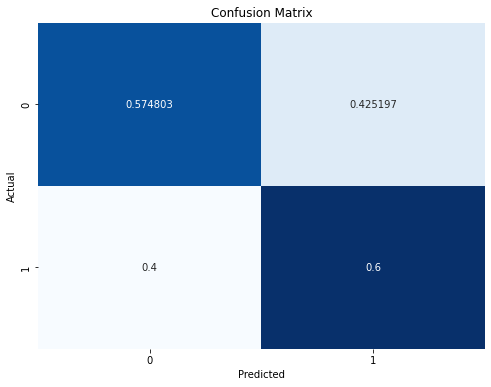

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can observe that the model is not detecting well the positive class instances, in fact, wrong detected ones are more than the good detected ones :S

**ROC Curve:**

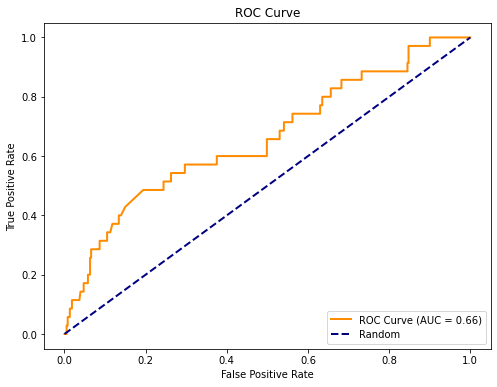

In [29]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {round(roc_auc, 2)})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

A 0.61 value in AUC gives us the clue that the model has some ability to discriminate between positive and negative instances. It is not a very sharp model, but the model's discriminatory power is slightly better than random guessing. 

Let's see if we have model overfitting:

In [30]:
y_pred_proba_train = model.predict_proba(X_train_processed)[:, 1]

In [31]:
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train)
roc_auc_train

0.8598875033884522

WE HAVE A LOT OF OVERFITTING. In the real world this would have to be mitigated, touching hyperparameters or attending to the train/test split more carefuly. Since we are just "playing" we are not going to give more importance. In more advanced notebooks, we will go through how the overfitting can be mitigated

## 5.4. Interpretion

We are going to attend to the feature importance of the model:

In [32]:
feature_importances = model.feature_importances_

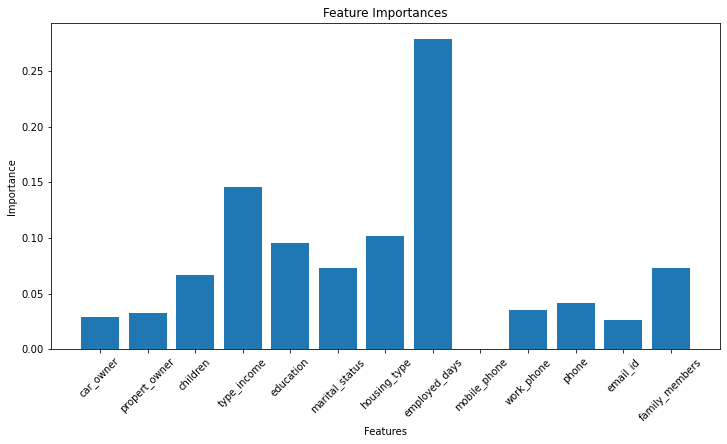

In [33]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importances)), feature_importances, tick_label=X_train.columns)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=45)
plt.show()

We observe that the variables employed_day and type_income are is the ones that gives us the biggest *discrimination*. This makes sense because this way we know if a person has been employed for a long or for a short time and his/her type of income!

Again, the same way we saw with the logistic regression, results show that the model is pretty poor. We'll need to introduce more complex algorithms. The good news is that we have learned to train a model using the simplest tree based algorithm, the decision tree!

**Let's move on!**